<a href="https://colab.research.google.com/github/m-njera/crop_disease/blob/master/Resnet_94_.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/drive


In [0]:
from fastai.vision import *
from fastai.metrics import error_rate

In [0]:
bs = 32

In [0]:
tfms = get_transforms(do_flip=True, flip_vert= True, xtra_tfms=[*zoom_crop(scale=(0.75,1.5), do_rand=True)])


In [0]:
data = ImageDataBunch.from_folder('/content/drive/My Drive/crop', train="train/", test='lot/test/', valid_pct=0.10, 
                                  ds_tfms=tfms, size=331,bs=bs, num_workers=0).normalize(imagenet_stats)

In [0]:
data.classes, data.c, len(data.train_ds), len(data.valid_ds)

(['healthy_wheat', 'leaf_rust', 'stem_rust'], 3, 790, 87)

In [7]:
learn = cnn_learner(data, models.resnet34, metrics=[error_rate, accuracy],callback_fns=ShowGraph)

Downloading: "https://download.pytorch.org/models/resnet34-333f7ec4.pth" to /root/.cache/torch/checkpoints/resnet34-333f7ec4.pth


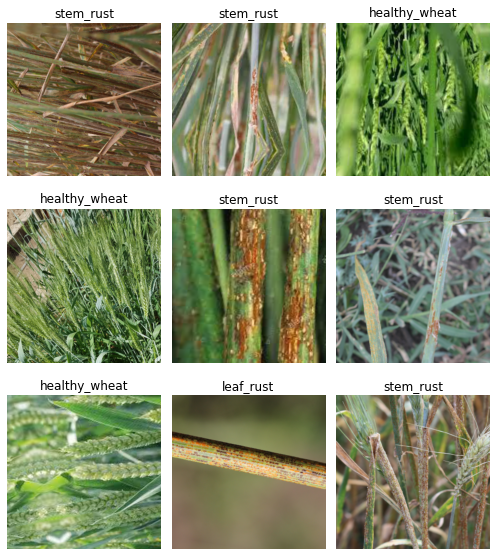

In [0]:
data.show_batch(rows=3, figsize=(7,8))

epoch,train_loss,valid_loss,error_rate,accuracy,time
0,1.664889,0.719124,0.264368,0.735632,16:29
1,1.245486,0.422076,0.149425,0.850575,03:44
2,1.080351,0.438121,0.206897,0.793103,03:20
3,0.925816,0.403881,0.172414,0.827586,03:18
4,0.814324,0.532926,0.149425,0.850575,03:23
5,0.720114,0.500639,0.160920,0.839080,03:15
6,0.668378,0.500938,0.149425,0.850575,03:12
7,0.647465,0.330673,0.126437,0.873563,03:09
8,0.602318,0.495501,0.137931,0.862069,03:10
9,0.562476,0.603796,0.149425,0.850575,03:09


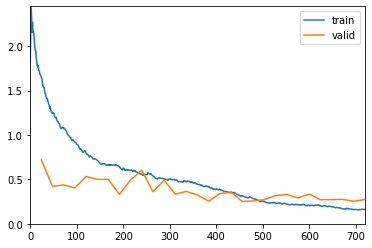

Better model found at epoch 0 with valid_loss value: 0.7191241383552551.
Better model found at epoch 1 with valid_loss value: 0.42207616567611694.
Better model found at epoch 3 with valid_loss value: 0.4038812518119812.
Better model found at epoch 7 with valid_loss value: 0.3306730389595032.
Better model found at epoch 14 with valid_loss value: 0.32421496510505676.
Better model found at epoch 15 with valid_loss value: 0.2553578019142151.
Better model found at epoch 18 with valid_loss value: 0.251981645822525.


In [8]:
from fastai.callbacks.tracker import *
learn.fit_one_cycle(30, max_lr=slice(3e-3,1e-2),callbacks=[SaveModelCallback(learn, monitor='valid_loss', name='resnet_final')])

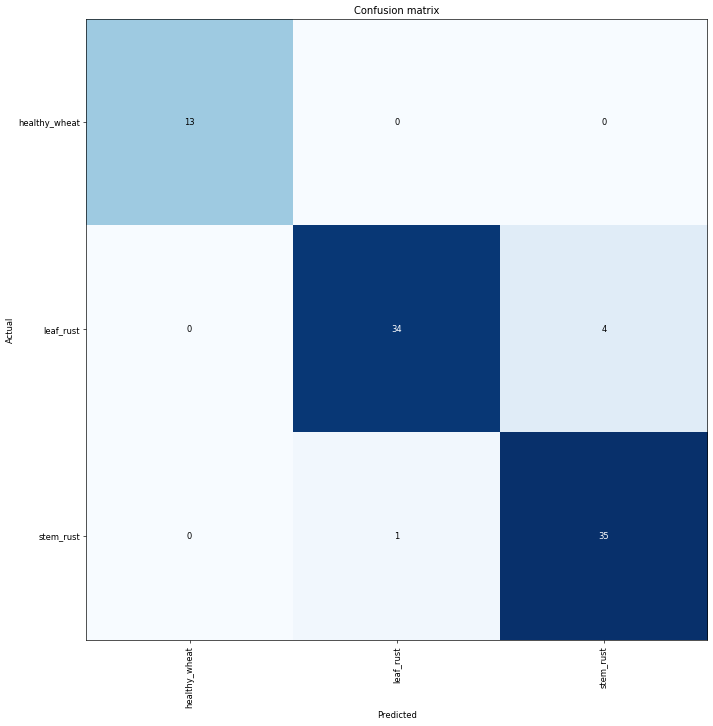

In [9]:
interp = ClassificationInterpretation.from_learner(learn)
losses,idxs = interp.top_losses()
len(data.valid_ds)==len(losses)==len(idxs)
interp.plot_confusion_matrix(figsize=(12,12), dpi=60)

In [0]:
learn2=learn

epoch,train_loss,valid_loss,error_rate,accuracy,time
0,0.199645,0.250695,0.057471,0.942529,03:19
1,0.223707,0.265605,0.057471,0.942529,03:26
2,0.211807,0.235733,0.057471,0.942529,03:19
3,0.208778,0.260468,0.068966,0.931035,03:20
4,0.201028,0.247568,0.057471,0.942529,03:22


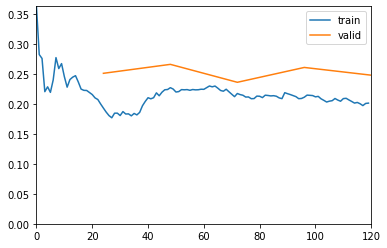

Better model found at epoch 0 with accuracy value: 0.9425287246704102.


In [11]:
from fastai.callbacks.tracker import *
#learn2.unfreeze()
# learn.fit_one_cycle(5, max_lr=slice(1e-5,1e-4))
learn.fit_one_cycle(5, max_lr=slice(1e-5,1e-4),callbacks=[SaveModelCallback(learn, monitor='accuracy', name='resnet_final')])

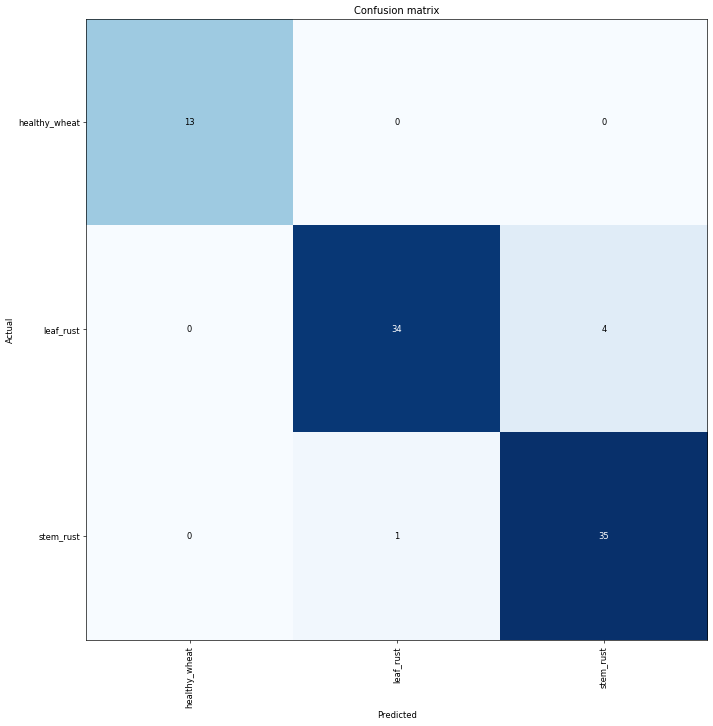

In [12]:
interp = ClassificationInterpretation.from_learner(learn)
losses,idxs = interp.top_losses()
len(data.valid_ds)==len(losses)==len(idxs)
interp.plot_confusion_matrix(figsize=(12,12), dpi=60)

epoch,train_loss,valid_loss,error_rate,accuracy,time
0,0.212209,0.259328,0.045977,0.954023,03:22
1,0.193191,0.255722,0.057471,0.942529,03:19
2,0.219661,0.249992,0.045977,0.954023,03:18
3,0.207199,0.252079,0.057471,0.942529,03:19
4,0.210298,0.255680,0.057471,0.942529,03:18


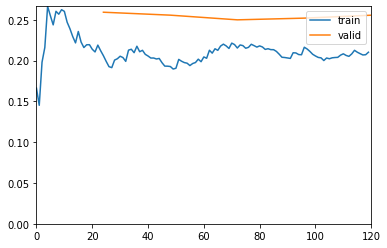

Better model found at epoch 0 with valid_loss value: 0.25932809710502625.
Better model found at epoch 1 with valid_loss value: 0.2557222545146942.
Better model found at epoch 2 with valid_loss value: 0.24999204277992249.


In [13]:
learn2.fit_one_cycle(5, max_lr=slice(1e-5,1e-4),callbacks=[SaveModelCallback(learn, monitor='valid_loss', name='resnet_final2')])

In [0]:
learn.save("trained_model_zindi", return_path=True)

PosixPath('/content/drive/My Drive/crop/models/trained_model_zindi.pth')

In [14]:
preds, y = learn.get_preds(DatasetType.Test)
npred = to_np(preds)

In [15]:
import os

submission = pd.DataFrame({'ID': [s.split('.')[0] for s in os.listdir('/content/drive/My Drive/crop/lot/test')  if s.split('.')[1] != 'jfif']})
for i, c in enumerate(learn.data.classes):
  submission[c] = npred[:,i]
submission = submission[['ID', 'leaf_rust', 'stem_rust', 'healthy_wheat']] # Get same order as sample sub 
submission.head()

,ID,leaf_rust,stem_rust,healthy_wheat
0,AD54KD,0.394588,0.593416,1.199548e-02
1,NN5F6I,0.999992,0.000008,9.063252e-09
2,NGZ2X2,0.000009,0.999963,2.760508e-05
3,OOALVQ,0.001594,0.998404,1.925494e-06
4,3UZ447,0.003051,0.984313,1.263592e-02


In [0]:
submission.to_csv("resnet_final.csv",index=False)